In [ ]:

from qiskit import quantum_info
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
#from qiskit_experiments.framework import ParallelExperiment

from qiskit.providers.aer import AerSimulator

from numpy.linalg import norm 
import cvxpy
#set noisy simulator backend 

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
#visualization
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator

ImportError: cannot import name 'FakeBackendV2' from 'qiskit.providers.fake_provider' (/home/alberto/.local/lib/python3.10/site-packages/qiskit/providers/fake_provider/__init__.py)

In [ ]:
#define unitary

def Ureal(A,T,G):  #NUMERICALLY CHECKED, CORRECT#
    
    Ur = np.zeros((4,4), dtype=complex)
    
    coef1=np.sqrt(1+A**(2)*(4*np.cosh(G/2)**(2)*(1/np.sinh(T)**(2))+(1/np.cosh(T/2)**2)))
    
    coef2=np.sqrt(2*A**(2)*(np.cosh(G)+np.cosh(T))+np.sinh(T)**2)
    
    
    Ur[0,0]=(1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    
    Ur[0,3]=(2*A*np.sinh(T/2))/coef2
    
    Ur[1,1]=(2*A*np.cosh(T/2))/coef2
    
    Ur[1,2]=(1j + 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    
    Ur[2,1]=(1j - 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    
    Ur[2,2]=(2*A*np.cosh(T/2))/coef2
    
    Ur[3,0]=-(2*A*np.sinh(T/2))/coef2
    
    Ur[3,3]=(-1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    
    return(Ur)



def UrealEv(A,T,G): 
    
    Ur = np.zeros((4,4), dtype=complex)
    
    coef1=np.sqrt(1+A**(2)*(4*np.cosh(G/2)**(2)*(1/np.sinh(T)**(2))+(1/np.cosh(T/2)**2)))
    
    coef2=np.sqrt(2*A**(2)*(np.cosh(G)+np.cosh(T))+np.sinh(T)**2)
    
    #even sector
    Ur[0,0]=(1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    Ur[0,3]=-(2*A*np.sinh(T/2))/coef2
    Ur[3,0]=(2*A*np.sinh(T/2))/coef2
    Ur[3,3]=(-1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    
    #odd sector
    Ur[1,1]=(2*A*np.cosh(T/2))/coef2
    Ur[1,2]=(1j + 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    Ur[2,1]=(1j - 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    Ur[2,2]=(2*A*np.cosh(T/2))/coef2

    return(Ur)

def bwassembler_z(qc,matrix,layers,n):    #CHECKED#
    
    m=0
    while m < layers:
        i=0;j=0;    
        #even layer
        while i < n/2:
            qc.unitary(matrix, [2*i,2*i+1])
            i+=1;
        qc.barrier(range(n)) 
        #odd layer
        while j < n/2:
            
            if j == (n/2 - 1):
                
                qc.unitary(perm4site(matrix),[0,1,2,3],label='ZZ')
                
            else:
                qc.unitary(matrix, [2*j+1,2*j+2])
            
            j+=1;
        qc.barrier(range(n))
        
        m+=1
    
    return(qc)

def bwassembler_zEv(qc,matrix1,matrix2,layers,n):    #CHECKED#
    
    m=0
    while m < layers:
        i=0;j=0;    
        #even layer
        while i < n/2:
            qc.unitary(matrix1, [2*i,2*i+1])
            i+=1;
        qc.barrier(range(n)) 
        #odd layer
        while j < n/2:
            
            if j == (n/2 - 1):
                
                qc.unitary(matrix2,[n-1,0],label='ZZ')
                
            else:
                qc.unitary(matrix1, [2*j+1,2*j+2])
            
            j+=1;
        qc.barrier(range(n))
        
        m+=1
    
    return(qc)

def perm4site(U):   #CHECKED#
    
    P = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]])
    
    P12 = np.kron(P,np.eye(4))
    P23 = np.kron(np.eye(2),np.kron(P,np.eye(2)))
    P34 = np.kron(np.eye(4),P)
    S34 = np.kron(np.eye(4),U)
    
    return P12@P23@P34@S34@P34@P23@P12
       
    
def prodstaten(n):   #CHECKED#
    
    X = np.array([[0,1],[1,0]])
    X0 = np.zeros((n,2**n,2**n),dtype = complex)
    
    for i in range(0,n):   
        X0[i]=np.kron(np.kron(np.eye(2**i),X),np.eye(2**(n-i-1)))
    operator = np.eye(2**n)
    for i in range(0,n//2):
        operator = (X0[2*i]-1j*X0[2*i+1])@operator
    return (1/np.sqrt(2**(n//2)))*operator



In [7]:
dispcolors = {'cx':('#426299', '#000000'),
            'cswap':('#705399', '#000000'),
              'cp':('#CFFF8B', '#000000')}

In [11]:
#check supercharge commutations 
def Q(T,G):
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])
    Id = np.array([[1,0],[0,1]])
    Q = np.exp(-(G+T)/4)*np.kron(X,Id)+np.exp((T+G)/4)*np.kron(Z,X)
    return Q

def Qbar(T,G):
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])
    Id = np.array([[1,0],[0,1]])
    Qbar = np.exp((T-G)/4)*np.kron(Y,Id)+np.exp(-(T-G)/4)*np.kron(Z,Y)

    return Qbar

A,T,G=3,3,3

print('Commutations for Ur: ',np.allclose(Q(T,G)@Ureal(A,T,G)-Ureal(A,T,G)@Q(-T,-G),0*np.eye(4)),
np.allclose(Qbar(T,G)@Ureal(A,T,G)-Ureal(A,T,G)@Qbar(-T,-G),0*np.eye(4)))

print('Commutations for Ur: ',np.allclose(Q(T,G)@UrealEv(A,T,G)-UrealEv(A,T,G)@Q(-T,-G),0*np.eye(4)),
np.allclose(Qbar(T,G)@UrealEv(A,T,G)-UrealEv(A,T,G)@Qbar(-T,-G),0*np.eye(4)))


Commutations for Ur:  True True
Commutations for Ur:  False False


In [172]:
#unitarity checks
mat=U(1,1,0)
uni = mat.conj().T@mat
mat1=Ureal(1,1,0)
uni1 = mat1.conj().T@mat1
print('Unitarity of U: ',np.allclose(np.eye(4),uni,atol=1e-15),'||| Unitarity of Ur: ',np.allclose(np.eye(4),uni1,atol=1e-15))

NameError: name 'U' is not defined

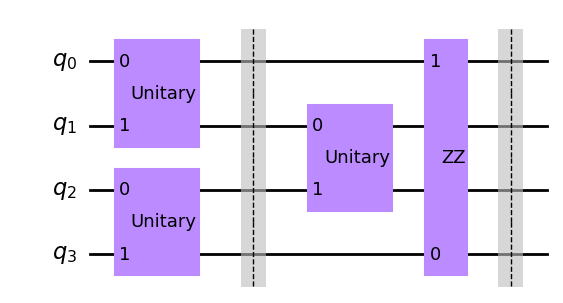

In [186]:
#modified unitary
n=4
a,t,g=1,1,1
qc = QuantumCircuit(n)
matrix1 = Ureal(a,t,g)
matrix2 = UrealEv(a,t,g)
bwassembler_zEv(qc,matrix1,matrix2,1,n)
op = Operator(qc)
op=op.data
qc.draw(output='mpl')

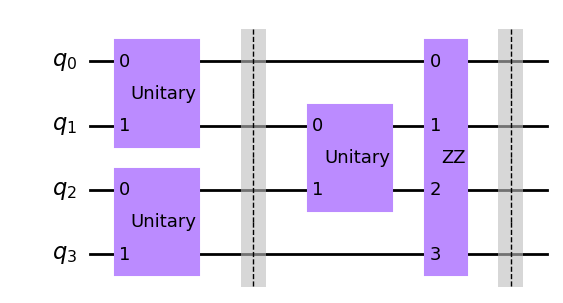

In [179]:
#normal unitary
n=4
a,t,g=1,1,1
qc = QuantumCircuit(n)
matrix = Ureal(a,t,g)
bwassembler_z(qc,matrix,1,n)
op1 = Operator(qc)
op1=op1.data
qc.draw(output='mpl')

In [175]:
#check supercharges commutation on 4 sites
#first trivial case, op1, we should have [QL,op1]=0
def x(t):
    return np.exp(t/4)
def y(g):
    return np.exp(g/4)
def Qplus(t,g):
    Ql12 = x(t)*y(g)*X(1,4)+(1/(x(t)*y(g)))*Z(1,4)@X(2,4)
    Ql34 = x(t)*y(g)*Z(1,4)@Z(2,4)@X(3,4)+(1/(x(t)*y(g)))*Z(1,4)@Z(2,4)@Z(3,4)@X(4,4)
    return Ql12+Ql34
def Qminus(t,g):
    Qr12 = (y(g)/x(g))*Y(1,4)+(x(t)/y(g))*Z(1,4)@Y(2,4)
    Qr34 = (y(g)/x(g))*Z(1,4)@Z(2,4)@Y(3,4)+(x(g)/y(g))*Z(1,4)@Z(2,4)@Z(3,4)@Y(4,4)
    return Qr12+Qr34
def X(n,L):
    X = np.array([[0,1],[1,0]])
    return (np.kron(np.eye(2**(n-1)),np.kron(X,np.eye(2**(L-n)))))
def Y(n,L):
    Y = np.array([[0,-1j],[1j,0]])
    return (np.kron(np.eye(2**(n-1)),np.kron(Y,np.eye(2**(L-n)))))    
def Z(n,L):
    Z = np.array([[1,0],[0,-1]])
    return (np.kron(np.eye(2**(n-1)),np.kron(Z,np.eye(2**(L-n)))))    

In [188]:
#normal unitary
print('Qplus is',np.allclose(op1@Qplus(t,g),Qplus(t,g)@op1),', Qmin is',np.allclose(op1@Qminus(t,g),Qminus(t,g)@op1)) 

Qplus is True , Qmin is True


In [187]:
#modified unitary
print('Qplus is',np.allclose(op@Qplus(t,g),Qplus(t,g)@op),', Qmin is',np.allclose(op@Qminus(t,g),Qminus(t,g)@op)) 

Qplus is False , Qmin is False


In [159]:
qc1 = QuantumCircuit(4)
qc1.unitary(perm4site(matrix),[0,1,2,3],label='ZZ')
oper1 = Operator(qc1)
oper1 = oper1.data

In [139]:
qc2 = QuantumCircuit(4)
matrix2 = UrealEv(a,t,g)
qc2.unitary(matrix2,[3,0])
oper2 = Operator(qc2)
oper2 = oper2.data

In [149]:
a,t,g=1,1,1
Q41plus = (1/(x(t)*y(g)))*Z(1,4)@Z(2,4)@Z(3,4)@X(4,4)+(x(t)*y(g))*X(1,4)
matrix = Ureal(a,t,g)
np.allclose(Q41plus@perm4site(matrix),perm4site(matrix)@Q41plus)

False